![Image](https://sawaed19.net/wp-content/uploads/2021/01/700600p546EDNmainimg-process-change-management1.jpg)

[Image Source](https://sawaed19.net/en/event/workshop-youth-for-change/)

# Introduction

Hey, thanks for viewing my Kernel!

If you like my work, please, leave an upvote: it will be really appreciated and it will motivate me in offering more content to the Kaggle community ! :)

The objective of this notebook is to explore the changes in data science over the years. Therefore, we worked on two different dataset that are [kaggle_survey_2021](https://www.kaggle.com/c/kaggle-survey-2021) and [kaggle_survey_2020](https://www.kaggle.com/c/kaggle-survey-2020/overview). Kaggle survey 2020 has 39+ questions, 20,036 responses and survey 2021 has 42+ questions, 25,973 responses. 

The notebook consists of 5 parts.
1. Introduction
2. Data Preparation
3. Data Cleaning
4. Data Analysis
5. Discussion

In the introduction part, we started simply importing libraries and datasets.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


warnings.simplefilter("ignore")
sns.set()

df21 = pd.read_csv('../input/kaggle-survey-2021/kaggle_survey_2021_responses.csv')
df20 = pd.read_csv('../input/kaggle-survey-2020/kaggle_survey_2020_responses.csv')

In [2]:
print(df20.shape, df21.shape)

(20037, 355) (25974, 369)


In [3]:
print(df20.columns)
print(df21.columns)

Index(['Time from Start to Finish (seconds)', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5',
       'Q6', 'Q7_Part_1', 'Q7_Part_2', 'Q7_Part_3',
       ...
       'Q35_B_Part_2', 'Q35_B_Part_3', 'Q35_B_Part_4', 'Q35_B_Part_5',
       'Q35_B_Part_6', 'Q35_B_Part_7', 'Q35_B_Part_8', 'Q35_B_Part_9',
       'Q35_B_Part_10', 'Q35_B_OTHER'],
      dtype='object', length=355)
Index(['Time from Start to Finish (seconds)', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5',
       'Q6', 'Q7_Part_1', 'Q7_Part_2', 'Q7_Part_3',
       ...
       'Q38_B_Part_3', 'Q38_B_Part_4', 'Q38_B_Part_5', 'Q38_B_Part_6',
       'Q38_B_Part_7', 'Q38_B_Part_8', 'Q38_B_Part_9', 'Q38_B_Part_10',
       'Q38_B_Part_11', 'Q38_B_OTHER'],
      dtype='object', length=369)


# Data Preparation

In this part we created 3 functions that are used for simplification the datasets. 

In the datasets, some questions have more than one column and function **group_cols** is used for grouping the questions. For example Q24 is one group and Q12_Part_1, Q12_Part_2, Q12_Part_3, Q12_OTHER are also one group. 

Function **part_cols_convert** is writed for converting the questions that have more than one column to one column. For instance, this function converts Q12_Part_1, Q12_Part_2, Q12_Part_3, Q12_OTHER to Q12 column. 

The last function is **dict_preparation** that is used for matching the same question in 2020 and 2021. Of course in the datasets, some questions mean are same but questions is different. We solved that kind of problem with manuel correction. For example Q12 is "Which types of specialized hardware do you use on a regular basis?  (Select all that apply) - Selected Choice - GPUs" in 2020 and "Which types of specialized hardware do you use on a regular basis?  (Select all that apply) - Selected Choice -  NVIDIA GPUs" in 2021

After all preparation, we combined  survey 2020 and 2021 by function **prepare_data**.

In [4]:
def group_cols(df):
    cols = df.columns
    
    col_part = []
    for col in cols:
        if '_' in col:
            col_part.append(col)
    
    cols_1 = list(set(cols) - set(col_part))
    
    temp_df = pd.DataFrame(col_part)
    temp_df['question'] = temp_df[0].str.split('_').str[0]
    temp_group = temp_df.groupby('question')[0]
    
    cols_2 = []
    for name, group in temp_group:
        if len(group) > 1:
            cols_2.append(list(group.values))
    
    return list(cols_1 + cols_2)

In [5]:
def part_cols_convert(df):
    cols = df.columns
    
    col_part = []
    for col in cols:
        if '_' in col:
            col_part.append(col)
    
    temp_df = pd.DataFrame(col_part)
    temp_df['question'] = temp_df[0].str.split('_').str[0]
    temp_group = temp_df.groupby('question')[0]
    
    cols_2 = []
    for name, group in temp_group:
        if len(group) > 1:
            cols_2.append(list(group.values))
    
    part_df_list = []
    for cols in cols_2:
        part_df = pd.DataFrame()
        new_col = cols[0].split('_')[0]
        
        values_list = []
        for col in cols:
            str_value = df.loc[0, col].split('-')[-1]
            count_num = df[col].value_counts()[0]
            values = [str_value for i in range(count_num)]
            values_list.extend(values)
        
        part_df[new_col] = values_list
        part_df_list.append(part_df)
    
    df_parts = pd.concat(part_df_list, 1)
    return df_parts

In [6]:
def dict_preparation(question_2020, question_2021, df20, df21):
    same_questions_dict = {}
    question_mean_dict = {}

    for c_20 in question_2020:
        if type(c_20) is list:
            c_20 = c_20[0]
            question_mean_dict[c_20.split('_')[0]] = df20.loc[0, c_20]
            #print('c_20:', c_20 , df20.loc[0, c_20])
        else:
            question_mean_dict[c_20] = df20.loc[0, c_20]
        q_20 = df20.loc[0, c_20]

        for c_21 in question_2021:
            if type(c_21) is list:
                c_21 = c_21[0]
            q_21 = df21.loc[0, c_21]
            #print('c_21:', c_21, q_21)
            if q_21 == q_20:
                if '_' in c_20:
                    if '_' in c_21:
                        same_questions_dict[c_20.split('_')[0]] = c_21.split('_')[0]
                    else:
                        same_questions_dict[c_20.split('_')[0]] = c_21
                else:
                    if '_' in c_21:
                        same_questions_dict[c_20] = c_21.split('_')[0]
                    else:
                        same_questions_dict[c_20] = c_21
                break
    return same_questions_dict, question_mean_dict

In [7]:
df20_parts = part_cols_convert(df20)
df21_parts = part_cols_convert(df21)

question_2020 = group_cols(df20)
question_2021 = group_cols(df21)

same_questions_dict, question_mean_dict = dict_preparation(question_2020, question_2021, df20, df21)

print(same_questions_dict)
print(question_mean_dict)

{'Time from Start to Finish (seconds)': 'Time from Start to Finish (seconds)', 'Q1': 'Q1', 'Q25': 'Q26', 'Q15': 'Q15', 'Q20': 'Q21', 'Q4': 'Q4', 'Q3': 'Q3', 'Q5': 'Q5', 'Q13': 'Q13', 'Q11': 'Q11', 'Q21': 'Q22', 'Q6': 'Q6', 'Q38': 'Q41', 'Q30': 'Q33', 'Q2': 'Q2', 'Q24': 'Q25', 'Q32': 'Q35', 'Q22': 'Q23', 'Q8': 'Q8', 'Q10': 'Q10', 'Q14': 'Q14', 'Q16': 'Q16', 'Q17': 'Q17', 'Q18': 'Q18', 'Q19': 'Q19', 'Q23': 'Q24', 'Q26': 'Q27', 'Q29': 'Q32', 'Q31': 'Q34', 'Q33': 'Q36', 'Q34': 'Q37', 'Q35': 'Q38', 'Q37': 'Q40', 'Q39': 'Q42', 'Q7': 'Q7', 'Q9': 'Q9'}
{'Time from Start to Finish (seconds)': 'Duration (in seconds)', 'Q1': 'What is your age (# years)?', 'Q25': 'Approximately how much money have you (or your team) spent on machine learning and/or cloud computing services at home (or at work) in the past 5 years (approximate $USD)?', 'Q15': 'For how many years have you used machine learning methods?', 'Q20': 'What is the size of the company where you are employed?', 'Q4': 'What is the highest lev

In [8]:
print(question_2020)
print(question_2021)

['Time from Start to Finish (seconds)', 'Q1', 'Q25', 'Q15', 'Q20', 'Q4', 'Q3', 'Q5', 'Q13', 'Q11', 'Q21', 'Q6', 'Q38', 'Q30', 'Q2', 'Q24', 'Q32', 'Q22', 'Q8', ['Q10_Part_1', 'Q10_Part_2', 'Q10_Part_3', 'Q10_Part_4', 'Q10_Part_5', 'Q10_Part_6', 'Q10_Part_7', 'Q10_Part_8', 'Q10_Part_9', 'Q10_Part_10', 'Q10_Part_11', 'Q10_Part_12', 'Q10_Part_13', 'Q10_OTHER'], ['Q12_Part_1', 'Q12_Part_2', 'Q12_Part_3', 'Q12_OTHER'], ['Q14_Part_1', 'Q14_Part_2', 'Q14_Part_3', 'Q14_Part_4', 'Q14_Part_5', 'Q14_Part_6', 'Q14_Part_7', 'Q14_Part_8', 'Q14_Part_9', 'Q14_Part_10', 'Q14_Part_11', 'Q14_OTHER'], ['Q16_Part_1', 'Q16_Part_2', 'Q16_Part_3', 'Q16_Part_4', 'Q16_Part_5', 'Q16_Part_6', 'Q16_Part_7', 'Q16_Part_8', 'Q16_Part_9', 'Q16_Part_10', 'Q16_Part_11', 'Q16_Part_12', 'Q16_Part_13', 'Q16_Part_14', 'Q16_Part_15', 'Q16_OTHER'], ['Q17_Part_1', 'Q17_Part_2', 'Q17_Part_3', 'Q17_Part_4', 'Q17_Part_5', 'Q17_Part_6', 'Q17_Part_7', 'Q17_Part_8', 'Q17_Part_9', 'Q17_Part_10', 'Q17_Part_11', 'Q17_OTHER'], ['Q18_Part

In [9]:
from termcolor import colored

diff_questions_20_list = ['Q12_Part_1', 'Q27_A_Part_1', 'Q27_B_Part_1', 'Q28_A_Part_1', 'Q28_B_Part_1', 'Q36_Part_1']
diff_questions_21_list = ['Q12_Part_1', 'Q27_A_Part_1', 'Q27_B_Part_1', 'Q28', 'Q36_A_Part_1', 'Q36_B_Part_1']
more_questions_list = ['Q40_Part_1', 'Q41', 'Q42_Part_1']

print(colored('1) ', 'green'), df20.loc[0, 'Q12_Part_1'], ' - ', df21.loc[0, 'Q12_Part_1'])
print(colored('2) ', 'green'), df20.loc[0, 'Q27_A_Part_1'], ' - ', df21.loc[0, 'Q27_A_Part_1'])
print(colored('3) ', 'green'), df20.loc[0, 'Q27_B_Part_1'], ' - ', df21.loc[0, 'Q27_B_Part_1'])

print(colored('3.5) ', 'green'), df20.loc[0, 'Q26_A_Part_1'], ' - ', df21.loc[0, 'Q27_A_Part_1'])

print(colored('4) ', 'red'), df20.loc[0, 'Q28_A_Part_1'], ' - ', df21.loc[0, 'Q28'])
print(colored('5) ', 'red'), df20.loc[0, 'Q28_B_Part_1'], ' - ', df21.loc[0, 'Q28'])
print(colored('6) ', 'red'), df20.loc[0, 'Q36_Part_1'], ' - ', df21.loc[0, 'Q36_A_Part_1'])
print(colored('7) ', 'red'), df20.loc[0, 'Q36_Part_1'], ' - ', df21.loc[0, 'Q36_B_Part_1'])

print(colored('8) ', 'blue'), df21.loc[0, 'Q40_Part_1'])
print(colored('9) ', 'blue'), df21.loc[0, 'Q41'])
print(colored('10) ', 'blue'), df21.loc[0, 'Q42_Part_1'])

same_questions_dict['Q12'] = 'Q12'

1)  Which types of specialized hardware do you use on a regular basis?  (Select all that apply) - Selected Choice - GPUs  -  Which types of specialized hardware do you use on a regular basis?  (Select all that apply) - Selected Choice -  NVIDIA GPUs 
2)  Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice -  Amazon EC2   -  Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) - Selected Choice -  Amazon Web Services (AWS) 
3)  In the next 2 years, do you hope to become more familiar with any of these specific cloud computing products? (Select all that apply) - Selected Choice -  Amazon EC2   -  Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years? - Selected Choice -  Amazon Web Services (AWS) 
3.5)  Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) - Selected 

In [10]:
not_exist_2020 = ['Q27', 'Q28', 'Q36']
not_exist_2021 = ['Q20', 'Q28', 'Q29', 'Q30', 'Q31', 'Q39']

print(colored('1) 2020 --- ', 'blue'), df20.loc[0, 'Q27_A_Part_1'])
print(colored('2) 2020 --- ', 'blue'), df20.loc[0, 'Q28_A_Part_1'])
print(colored('3) 2020 --- ', 'blue'), df20.loc[0, 'Q36_Part_1'])
print()
print(colored('1) 2021 --- ', 'red'), df21.loc[0, 'Q20'])
print(colored('2) 2021 --- ', 'red'), df21.loc[0, 'Q28'])
print(colored('3) 2021 --- ', 'red'), df21.loc[0, 'Q29_A_Part_1'])
print(colored('4) 2021 --- ', 'red'), df21.loc[0, 'Q30_A_Part_1'])
print(colored('5) 2021 --- ', 'red'), df21.loc[0, 'Q31_A_Part_1'])
print(colored('6) 2021 --- ', 'red'), df21.loc[0, 'Q39_Part_1'])

same_questions_dict['Q27'] = 'Q29'
same_questions_dict['Q28'] = 'Q31'
same_questions_dict['Q36'] = 'Q39'

1) 2020 ---  Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice -  Amazon EC2 
2) 2020 ---  Do you use any of the following machine learning products on a regular basis? (Select all that apply) - Selected Choice -  Amazon SageMaker 
3) 2020 ---  Where do you publicly share or deploy your data analysis or machine learning applications? (Select all that apply) - Selected Choice -  Plotly Dash 

1) 2021 ---  In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice
2) 2021 ---  Of the cloud platforms that you are familiar with, which has the best developer experience (most enjoyable to use)? - Selected Choice
3) 2021 ---  Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice -  Amazon Elastic Compute Cloud (EC2) 
4) 2021 ---  Do you use any of the following data storage products on a regular basis? (Selec

In [11]:
def prepare_data(same_questions_dict, df20, df21, df20_parts, df21_parts):
    cols_20, cols_21 = [], []
    part_cols_20, part_cols_21 = [], []
    for key in same_questions_dict.keys():
        if key in df20_parts.columns:
            part_cols_20.append(key)
            part_cols_21.append(same_questions_dict[key])
        else:
            cols_20.append(key)
            cols_21.append(same_questions_dict[key])
    
    df20['years'] = 2020
    df21['years'] = 2021
    df20_parts['years'] = 2020
    df21_parts['years'] = 2021
    
    cols_20.append('years')
    cols_21.append('years')
    part_cols_20.append('years')
    part_cols_21.append('years')
    
    temp_df21 = df21[cols_21]
    temp_df21.columns = cols_20
    temp_df21_parts = df21_parts[part_cols_21]
    temp_df21_parts.columns = part_cols_20
    
    df_20_21 = pd.concat([df20[cols_20].loc[1:, :], temp_df21.loc[1:, :]], join='outer')
    df_part_20_21 = pd.concat([df20_parts[part_cols_20].loc[1:, :], temp_df21_parts.loc[1:, :]], join='outer')
    
    return df_20_21, df_part_20_21

In [12]:
df_20_21, df_part_20_21 = prepare_data(same_questions_dict, df20, df21, df20_parts, df21_parts)

print(df_20_21.shape)
print(df_part_20_21.shape)

(46009, 20)
(116578, 22)


# Data Cleaning

Data cleaning is one of the most important part of data science. As with most datasets, this dataset needs data cleaning. According to my view, some answers were split like 'Product/Project Manager' to 'Program/Project Manager', 'Product Manager' and some answers have been fixed like PostgresSQL to PostgreSQL in 2021. In the below, we tried to match the same answers.

In [13]:
df_20_21_clean = df_20_21.copy()
df_part_20_21_clean = df_part_20_21.copy()

df_20_21_clean['Q6'] = df_20_21_clean['Q6'].str.replace('1-3 years', '1-2 years')
df_20_21_clean['Q30'] = df_20_21_clean['Q30'].str.replace('PostgresSQL', 'PostgreSQL')
df_20_21_clean['Q4'] = df_20_21_clean['Q4'].str.replace('Professional degree', 'Professional doctorate')
df_20_21_clean['Q5'] = df_20_21_clean['Q5'].str.replace('Program/Project Manager', 'Product/Project Manager')
df_20_21_clean['Q5'] = df_20_21_clean['Q5'].str.replace('Product Manager', 'Product/Project Manager')
df_20_21_clean['Q24'] = df_20_21_clean['Q24'].str.replace('$', '')
df_20_21_clean['Q24'] = df_20_21_clean['Q24'].str.replace('300,000-499,999', '300,000-500,000')
df_20_21_clean['Q24'] = df_20_21_clean['Q24'].str.replace('500,000-999,999', '> 500,000')
df_20_21_clean['Q24'] = df_20_21_clean['Q24'].str.replace('>1,000,000', '> 500,000')
df_20_21_clean['Q11'] = df_20_21_clean['Q11'].str.replace('A personal computer / desktop', 'A personal computer or laptop')
df_20_21_clean['Q11'] = df_20_21_clean['Q11'].str.replace('A laptop', 'A personal computer or laptop')

df_part_20_21_clean['Q10'] = df_part_20_21_clean['Q10'].str.replace('  Amazon Sagemaker Studio Notebooks ', '  Amazon Sagemaker Studio ')
df_part_20_21_clean['Q10'] = df_part_20_21_clean['Q10'].str.replace('\n', '')
df_part_20_21_clean['Q10'] = df_part_20_21_clean['Q10'].str.replace(' Google Cloud Datalab Notebooks', ' Google Cloud Datalab')
df_part_20_21_clean['Q10'] = df_part_20_21_clean['Q10'].str.replace(' Google Cloud AI Platform Notebooks ', ' Google Cloud Notebooks (AI Platform / Vertex AI) ')
df_part_20_21_clean['Q29'] = df_part_20_21_clean['Q29'].str.replace('PostgresSQL', 'PostgreSQL')
df_part_20_21_clean['Q29'] = df_part_20_21_clean['Q29'].str.replace('\n', '')
df_part_20_21_clean['Q29'] = df_part_20_21_clean['Q29'].str.replace(' Microsoft Azure SQL Database ', ' Microsoft Azure Data Lake Storage ')
df_part_20_21_clean['Q29'] = df_part_20_21_clean['Q29'].str.replace(' Microsoft Azure Cosmos DB ', ' Microsoft Azure Data Lake Storage ')
df_part_20_21_clean['Q33'] = df_part_20_21_clean['Q33'].str.replace('\n', '')
df_part_20_21_clean['Q33'] = df_part_20_21_clean['Q33'].str.replace('(', '')
df_part_20_21_clean['Q33'] = df_part_20_21_clean['Q33'].str.replace(')', '')
df_part_20_21_clean['Q33'] = df_part_20_21_clean['Q33'].str.replace(' Automation of full ML pipelines e.g. Google AutoML, H2O Driverless AI', 
                                                        ' Automation of full ML pipelines AutoML')
df_part_20_21_clean['Q33'] = df_part_20_21_clean['Q33'].str.replace(' Automation of full ML pipelines e.g. Google Cloud AutoML, H2O Driverless AI', 
                                                        ' Automation of full ML pipelines Cloud AutoML')
df_part_20_21_clean['Q33'] = df_part_20_21_clean['Q33'].str.replace(' Automation of full ML pipelines e.g. Google AutoML, H20 Driverless AI', 
                                                        ' Automation of full ML pipelines AutoML')
df_part_20_21_clean['Q33'] = df_part_20_21_clean['Q33'].str.replace(' Automation of full ML pipelines e.g. Google Cloud AutoML, H20 Driverless AI', 
                                                        ' Automation of full ML pipelines Cloud AutoML')
df_part_20_21_clean['Q34'] = df_part_20_21_clean['Q34'].str.replace('  H20 Driverless AI  ', '  H2O Driverless AI  ')
df_part_20_21_clean['Q9'] = df_part_20_21_clean['Q9'].str.replace('  Visual Studio / Visual Studio Code ', '  VisualStudio ')
df_part_20_21_clean['Q9'] = df_part_20_21_clean['Q9'].str.replace('(', '')
df_part_20_21_clean['Q9'] = df_part_20_21_clean['Q9'].str.replace(')', '')
df_part_20_21_clean['Q9'] = df_part_20_21_clean['Q9'].str.replace('  Visual Studio Code VSCode ', '  VisualStudio ')
df_part_20_21_clean['Q9'] = df_part_20_21_clean['Q9'].str.replace('  Visual Studio ', '  VisualStudio ')
df_part_20_21_clean['Q9'] = df_part_20_21_clean['Q9'].str.replace('  VisualStudio ', '  Visual Studio / Visual Studio Code ')
df_part_20_21_clean['Q9'] = df_part_20_21_clean['Q9'].str.replace(' Jupyter (JupyterLab, Jupyter Notebooks, etc) ', '  Jupyter Notebook')
df_part_20_21_clean['Q9'] = df_part_20_21_clean['Q9'].str.replace('  Jupyter Notebook', ' Jupyter (JupyterLab, Jupyter Notebooks, etc) ')
df_part_20_21_clean['Q12'] = df_part_20_21_clean['Q12'].str.replace('  Google Cloud TPUs ', ' TPUs')
df_part_20_21_clean['Q12'] = df_part_20_21_clean['Q12'].str.replace('  NVIDIA GPUs ', ' GPUs')
df_part_20_21_clean['Q27'] = df_part_20_21_clean['Q27'].str.replace('  Amazon Elastic Container Service ', '  Amazon Elastic Compute Cloud (EC2) ')
df_part_20_21_clean['Q27'] = df_part_20_21_clean['Q27'].str.replace('  Microsoft Azure Container Instances ', '  Microsoft Azure Virtual Machines ')


#print(df_20_21_clean['Q11'].unique())

# Data Analysis

In this part, we plotted all questions for visual pieces of information. We created 2 functions. 

Function **long_sentences_seperate** is used for visual editing. For instance, if a question or an answer text is so long for plotting, this function splits the text by adding '\n' to the text.

The **barplot_all_cols** function is used for plotting all columns. For color, we selected the 'years' column.

In [14]:
def long_sentences_seperate(sentence, step=10):
    try:
        splittext = sentence.split(" ")
        for x in range(step, len(splittext), step):
            splittext[x] = "\n"+splittext[x].lstrip()
        text = " ".join(splittext)
        return text
    except:
        return sentence

In [15]:
def barplot_all_cols(df, question_mean_dict, df_cols, figsize=(24, 96)):
    response_num_2020 = df20.shape[0]
    response_num_2021 = df21.shape[0]
    
    ncols = 2
    nrows = round(len(df_cols) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    plt.subplots_adjust(hspace=0.3)
    
    index = 0
    for row in range(nrows):
        for col in range(ncols):
            try:
                col_name = df_cols[index]
                question = question_mean_dict[col_name]
                question = long_sentences_seperate(question, step=10)
            except:
                axes[row][col].set_visible(False)
                continue
            
            if col_name == 'Q3':
                selected_countries = df[col_name].value_counts(normalize=True).index[:10]
                temp_df = df[df[col_name].isin(selected_countries)]
                
                temp_df = temp_df.groupby([col_name, 'years']).agg({col_name:'count'})
                temp_df.columns = ['counts']
                temp_df.reset_index(inplace=True)
            else:
                temp_df = df.groupby([col_name, 'years']).agg({col_name:'count'})
                temp_df.columns = ['counts']
                temp_df.reset_index(inplace=True)
            
            temp_df.loc[temp_df['years'] == 2020, 'counts_norm'] = temp_df.loc[temp_df['years'] == 2020, 'counts'] / response_num_2020
            temp_df.loc[temp_df['years'] == 2021, 'counts_norm'] = temp_df.loc[temp_df['years'] == 2021, 'counts'] / response_num_2021
            temp_df[col_name] = temp_df[col_name].apply(lambda x: long_sentences_seperate(x, step=4))
            
            ### Find The Order That Biggest Change to Lowest Change
            count_df = temp_df[col_name].value_counts()
            selected_values = list(count_df[count_df > 1].index)
            clean_temp_df = temp_df[temp_df[col_name].isin(selected_values)]
            changes_list = ((clean_temp_df.loc[clean_temp_df['years'] == 2021, 'counts'].values - clean_temp_df.loc[clean_temp_df['years'] == 2020, 'counts'].values) / 
                            clean_temp_df.loc[clean_temp_df['years'] == 2020, 'counts'].values)
            change_twice_list = []
            for value in changes_list:
                change_twice_list.append(value)
                change_twice_list.append(value)
            clean_temp_df['change'] = change_twice_list
            clean_temp_df.sort_values('change', inplace=True, ascending=False)
            order_list = list(clean_temp_df[col_name].unique())
            temp_df_unique = temp_df[col_name].unique()
            diff_order = list(set(temp_df_unique) - set(order_list))
            if len(diff_order) > 0:
                order_list.extend(diff_order)
            ###
            
            sns.barplot(data=temp_df, x='counts_norm', y=col_name, hue='years', order=order_list, ax=axes[row][col])
            axes[row][col].set_title(question)
            for p in axes[row][col].patches:
                txt = str(p.get_width().round(3))
                txt_x = p.get_width() 
                txt_y = p.get_y() + p.get_height() * 2 / 5
                bar_color = p.get_facecolor()
                try:
                    if bar_color == (0.34705882352941175, 0.4588235294117645, 0.6411764705882353, 1.0):
                        txt_count = str(round(p.get_width() * response_num_2020))
                    elif bar_color == (0.7985294117647057, 0.536764705882353, 0.38970588235294135, 1.0):
                        txt_count = str(round(p.get_width() * response_num_2021))
                except:
                    txt_count = 0
                txt_count_y = p.get_y() + p.get_height() * 4 / 5
                axes[row][col].text(txt_x,txt_y,txt,color=bar_color)
                axes[row][col].text(txt_x,txt_count_y,txt_count,color=bar_color)
            
            index += 1

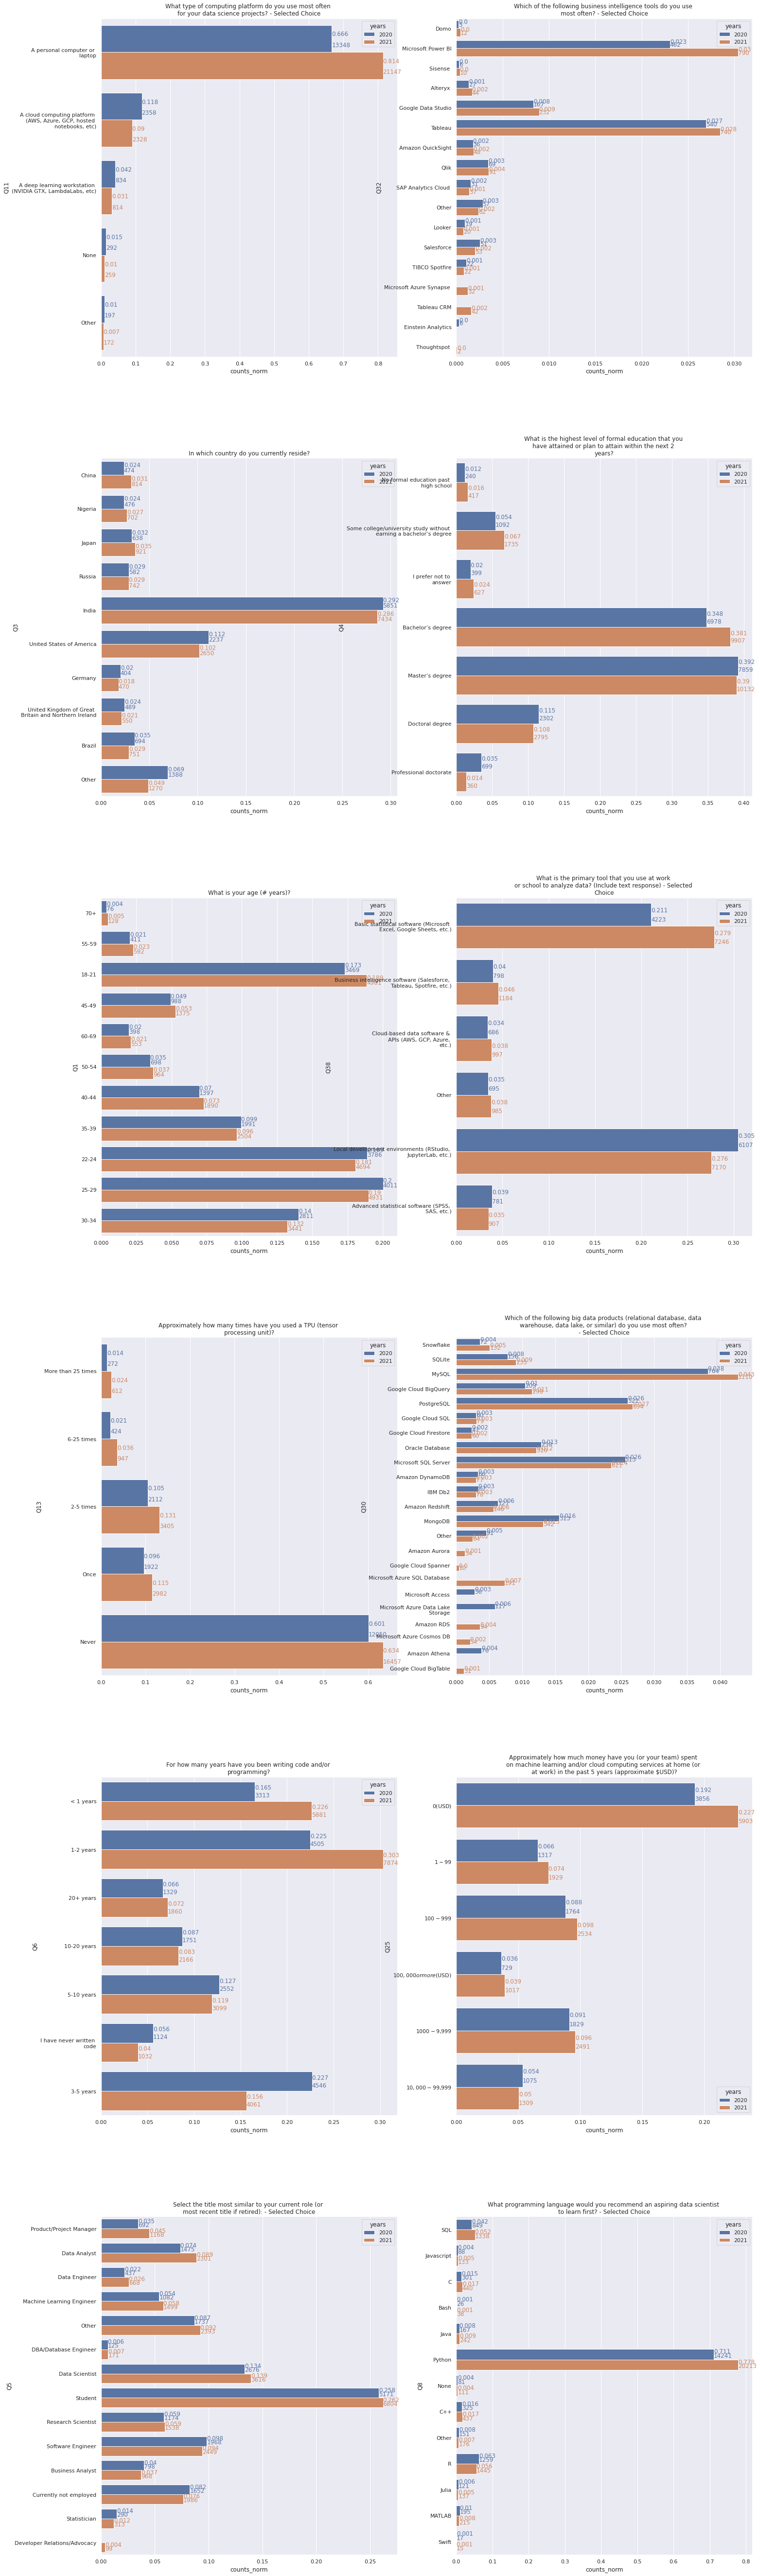

In [16]:
DS_col = ['Q11', 'Q32', 'Q3', 'Q4', 'Q1', 'Q38', 'Q13', 'Q30', 'Q6', 'Q25', 'Q5', 'Q8']

barplot_all_cols(df_20_21_clean, question_mean_dict, DS_col)

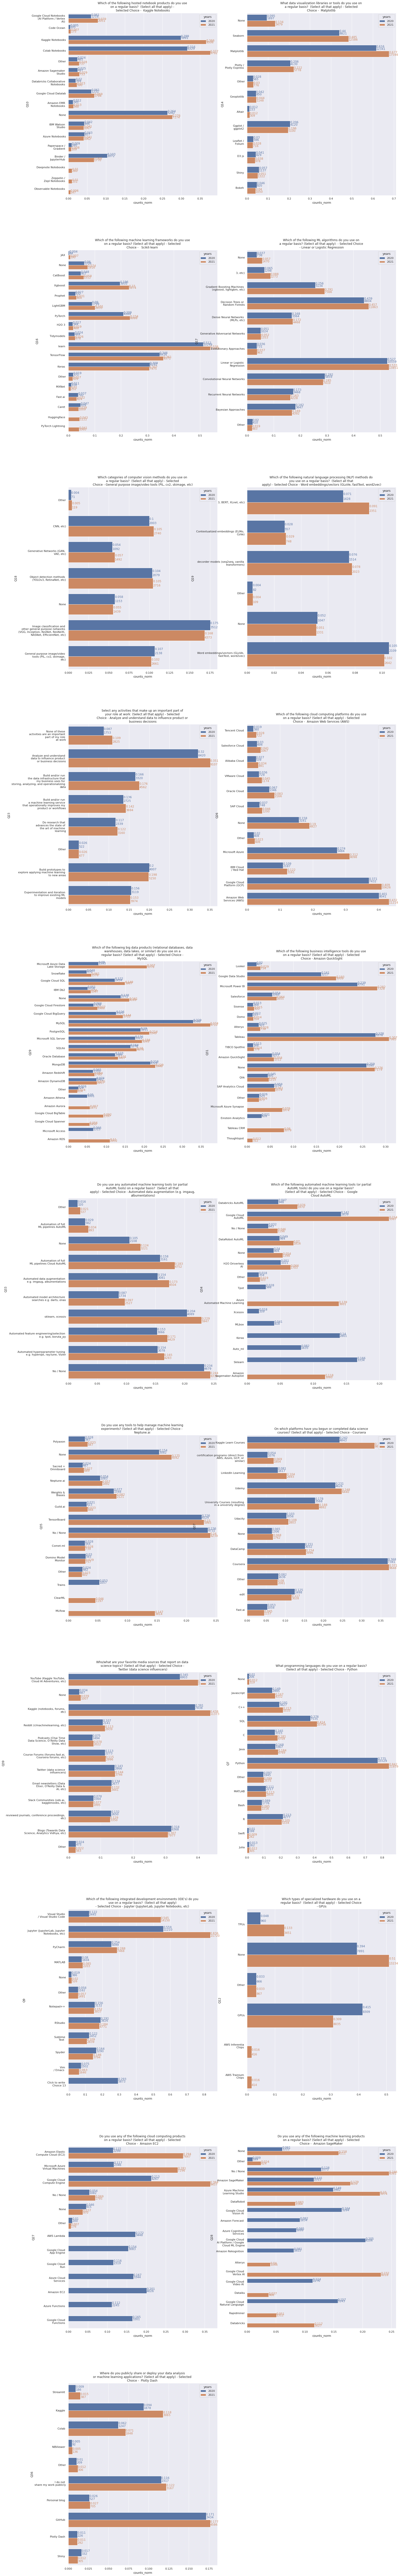

In [17]:
barplot_all_cols(df_part_20_21_clean, question_mean_dict, df_part_20_21_clean.columns, figsize=(24, 192))

# Discussion

1. **Computing Platforms**: In 2021, usage of cloud computing platform(AWS, Azure, GCP) and deep learning workstation(NVDIA GTX, etc) a little bir decrease and personal computer or labtop usage is increase
2. **Business Intelligence Tool**: Microsoft Power BI increase 462 to 790 and Tableau increase 540 to 740. We can say Microsoft Power BI is the future.
3. **Country**: The number of Data Scientists increased around all of the world. Most increase in China.
4. **Education**: Ungraduated and Bachelor's degree increase but Professional doctorate decrease from 699 to 360. That is almost half.
5. **Age**: in 2020 most common age was 22-24, now, it is 18-21. 70+ increase from 76 to 128. that is almost double.
6. **Primary Tool For Data Analysis**: Basic statistical software(Excel, Google Sheets, etc.) increase from 4223 to 7246.
7. **TPU**: 2-5 times increase 2012 to 3405, 6-25 increase 424 to 947 and 25+ increase 272 to 612. We can say TPU is the future.
8. **Data Product**: In generaly, usage of all of the data product increase. We said in this kaggle notebook. databases important for data scientist. Most increase in MySQL.
9. **Experiences**: "I have never writen code" is decrease even if 18-21 age increase. We can say "code age is decrease". There is a decrease in 3-5 years from 4546 to 4061. This can be cause of some data scients use Kaggle for a good job and after that they don't use.
10. **Spent Money For ML**: In generaly spending money for ml increase.
11. **Job Title**: In generaly, all of the jobs increase but Business Analyst and Statistician increase a little bit. Now, we have new job title that is Developer Relations/Advocacy.
12. **Recommend Programing Language:** Only Swift decrease. Most increase in SQL

...

13. **Hosted Notebook**: Binder/JupyterHub decrease 2072 to 1770 and Kaggle Notebooks increase 5991 to 9506, Colab Notebooks increase 6329 to 9792. Most increase in Google Cloud Notebooks (AI Platform / Vertex AI)
14. **Vizualization Lib**: All usage of data vizualization increase and the most increase in Seaborn 8821 to 12586.
15. **ML Frameworks**: Tensorflow, Pytorch and Xgboost all increase but most increase in Xgboost 3935 to 5974, CatBoost 957 to 1512 and JAX 84 to 190. Also we have need selection that are Huggingface and Pytorch Lightning.
16. **Computer Vision Method**: All usage of computer vision algorithm incerase but most increase in CNN 2003 to 2740 and GAN 1092 to 1492.
17. **NLP Method**: All usage of NLP increase but most increase in BERT 1428 to 2351.
18. **Most Important Part of Work**: Most percantage in anaylze and understand data to produt or business decisions 6420 to 9107. it is %351 of data scientist. And most increase in None of these activities are an important part of my role in work. It should should be questioned.
19. **Cloud Computing**: All usage of the cloud computing increase but most increase. Most famous cloud computing tools are AWS, GCP, Microsoft Azure.
20. **Automated ML Tools**: Automated ML Tools will be used for ML pipelines in 2022. 
21. **Automated ML Tools**: Most increase in Databricks AutoML 948 to 1970 and Google Cloud AutoML 2839 to 5567. Also Google AutoML is most famuos. Amazob Sagemaker Autopilot and Azure Automate Machine Learning are new.
22. **Cources**: Most increase in Kaggle Learn Cources but this data is not trustable. Other important cources is Certification Programs(AWS, Azure, GCP, etc) increase 1076 to 1804 and LinkdIn Learning increase 1617 to 2093.
23. **Media Sources For Data Science**: All usage of media increase but most increase in Youtube, Kaggle and Reddit.
24. **Programming Language**: Most increase in Javascript 2995 to 4332, c++ 3827 to 5535 and SQL 7535 to 10756.
25. **IDE**: All usage of the IDEs increase. Most increase in Visual Studio / Visual Studio Code 2445 to 14150. Second is Jupyter 11210 to 21720.
26. **Hardware**: GPUs decrease 8309 to 8035 and TPUs increase 960 to 3451.
29. **Share or Deploy**: Famous share or deploy is Github 3434 to 4586. Most increas in Streamlit 186 to 387, Kaggle 1878 to 3065 and Colab to 1247 to 1848.

...
Question
27. **Cloud Computing Product**: I am not sure about Q27. For example, Are Azure Cloud Services and Azure Functions part of Microsoft Azure Virtual Machines or a lot of cloud computing products are death in 2021? If you know, please comment.
28.  I am not sure about Q28. For example, Are Google Cloud Natural Language and Google Cloud Video AI part of Google Cloud Vertex AI or a lot of machine learning products are death in 2021? If you know, please comment.